In [1]:
import pandas as pd
import numpy as np
#-----------------------------------------Scikit----------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
#------------------------------------import feature selection----------------------------------
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2            #score_func, need to normalize to remove negative to use
from sklearn.feature_selection import f_classif
#-----------------------------------------Seaborn----------------------------------------------
import matplotlib.pyplot as plt
import ssl
import seaborn as sns
ssl._create_default_https_context = ssl._create_unverified_context
sns.set(style='darkgrid')

In [2]:
df = pd.read_csv('./Data/features_30_sec.csv')          #read file

In [3]:
df.head()                                               #display first 5 rows of data

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
df = df.drop(['length','filename'],axis=1)             #remove the length and filename column since irrelevant
df = df.sample(frac=1)                                 #randomize rows of dataset every run

<AxesSubplot:xlabel='chroma_stft_mean', ylabel='mfcc1_mean'>

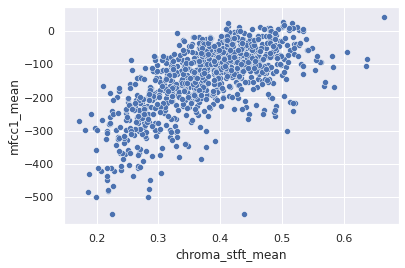

In [5]:
sns.scatterplot(data = df, x ='chroma_stft_mean',y='mfcc1_mean',hue='label')

In [6]:
#-----------------------------------------Encode The Genre Into Numbers-----------------------------------------
labelEncoder = LabelEncoder()                              #store encoded labels into variable
le = labelEncoder.fit(df['label'])                         #fit label into the variable
df['label'] = le.transform(df['label'])                    #transform label values into numbers
Y_genre = df['label']                                      #Assign label to Y_genre
X_features = df.drop('label',axis=1)                       #Assign all features to X_feature

In [7]:
#---------------------------------------Normalize the features between 0-1---------------------------------------
scalar = MinMaxScaler()                                    
scalar.fit(X_features)                                     #Fit features into scalar
X_cols = X_features.columns
X_features[X_cols] = scalar.transform(X_features)                 #Transform features into 0-1

In [8]:
#------------------------------Scatterplot of Data--------------------------------------------------
#sns.scatterplot(data = df, x ='chroma_stft_var',y='rolloff_mean',hue='label')

In [9]:
#------------------------------------------Feature Reduction-----------------------------------------------------
best_feat = SelectKBest(score_func= f_classif, k=4)          #Auto select 4 features that best differentiate
fit = best_feat.fit(X_features,Y_genre)                      #the genres

In [10]:
feat_scores = pd.DataFrame(fit.scores_)                      #Extract optimum score of each feature
feat_columns = pd.DataFrame(X_features.columns)              #Extract the column names

In [11]:
sel_scores = pd.concat([feat_columns,feat_scores],axis=1)    #Concatenate the two
sel_scores.columns = ['Features','Scores']                   #Name the two new columns

In [12]:
sel_scores.sort_values(by=['Scores'],ascending=False)        #Sort the scores so that highest is displayed first
sel_largest = sel_scores.nlargest(4,'Scores')                #Display the 4 best ones
sel_largest

,Features,Scores
0,chroma_stft_mean,176.453282
17,mfcc1_mean,130.371835
6,spectral_bandwidth_mean,116.601879
8,rolloff_mean,110.871317


In [13]:
X_features = X_features[sel_largest['Features'].T]           #Reduce the features to the 4 with best scores

In [14]:
#-------------------------------------Split data into train and test----------------------------------------
#rs = 42
#X_train,X_test,y_train,y_test = train_test_split(X_features,Y_genre,test_size=0.25,random_state=rs)

In [15]:
#-----------------------------------------Import algorithms------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier

In [16]:
df = df.sample(frac=1)                                #randomize rows of dataset
row,col = pd.concat([X_features,Y_genre],axis=1).shape  #extract size of dataset
split = 0.75                                          #3/4 training split
X_train = df.iloc[:int(row*split),:-1]             #obtain 75% of test data
y_train = df.iloc[:int(row*split),-1:]            #obtain 75% of genre data
X_test = df.iloc[int(row*split):,:-1]              #obtain 25% of test data
y_test = df.iloc[int(row*split):,-1:]             #obtain 25% of genre data

In [17]:
clf = RandomForestClassifier(n_estimators=180, max_depth=None,min_samples_split=4,min_samples_leaf=2,
                             max_features='auto')
clf.fit(X_train,y_train.values.ravel())

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=180)

In [18]:
clf.score(X_test,y_test)

0.7

In [19]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = np.arange(50,200,10)
# max_features = ['auto','sqrt']
# max_depth = [None]
# min_samples_leaf = [1,2,3]
# min_samples_split = [2,4]

# parameters = {'n_estimators':n_estimators,
#               'max_features':max_features,
#               'min_samples_leaf':min_samples_leaf,
#               'min_samples_split':min_samples_split,
#               'max_depth':max_depth}

In [20]:
# clfGridSearch = RandomForestClassifier()
# rf_Grid = GridSearchCV(clfGridSearch,parameters,cv=3,verbose=2,n_jobs=4)

In [21]:
# %%time
# rf_Grid.fit(X_train,y_train.values.ravel())
# print('Best Scores:',rf_Grid.best_score_)
# print('Best Parameters:',rf_Grid.best_params_)